In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FunctionTransformer, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score
from sklearn.ensemble import IsolationForest

import pickle


warnings.filterwarnings('ignore')

In [74]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print('Accuracy:', round(accuracy_score(y_test, y_pred),2))
    print('Precision:', round(precision_score(y_test, y_pred),2))
    print('Recall:', round(recall_score(y_test, y_pred),2))
    print('F1 score:', round(f1_score(y_test, y_pred),2))

In [75]:
data = pd.read_csv('../data/preprocessing_data.csv')  
data.drop(columns=['Unnamed: 0'], inplace= True)

In [76]:
X = data.drop(['diagnosis'], axis=1)
y = data['diagnosis']

In [77]:
skewed_cols = ['area_mean','compactness_mean','concavity_mean','concave points_mean','fractal_dimension_mean','radius_se',
 'texture_se','perimeter_se','area_se','smoothness_se','compactness_se','concavity_se','concave points_se','symmetry_se',
 'fractal_dimension_se','radius_worst','perimeter_worst','area_worst','compactness_worst','concavity_worst','symmetry_worst',
 'fractal_dimension_worst']

In [78]:
iso = IsolationForest(
    contamination=0.05,
    random_state=42
)

y_pred_outliers = iso.fit_predict(X)

mask = y_pred_outliers != -1
X_clean = X[mask]
y_clean = y[mask] 

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

In [80]:
log_transformer = FunctionTransformer(np.log1p, validate= True)

scaler = StandardScaler()

pca = PCA(0.95)

preprocessor = ColumnTransformer(transformers=[('log_transformer', log_transformer, skewed_cols), 
                                               ('scaler', scaler, X.columns),
                                                ("pca", pca, X.columns)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', LogisticRegression(random_state=42, max_iter=500))])

In [81]:
param_grid = {"model__penalty": ["l1", "l2", "elasticnet", None],
            "model__C": [0.01, 0.1, 1, 10, 100],
            "model__solver": ["liblinear", "saga"]}


gridsearch = GridSearchCV(param_grid=param_grid, estimator= pipeline, scoring='f1',cv= 5, n_jobs= -1)
gridsearch.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__C': [0.01, 0.1, ...], 'model__penalty': ['l1', 'l2', ...], 'model__solver': ['liblinear', 'saga']}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('log_transformer', ...), ('scaler', ...), ...]"


In [82]:
best_lr = gridsearch.best_estimator_

In [83]:
scores_cv = cross_val_score(best_lr, X_train, y_train, cv=5, scoring='f1')
scores_cv.mean()

np.float64(0.9606451612903225)

In [84]:
evaluate_model(best_lr, X_test, y_test)

Accuracy: 0.97
Precision: 0.97
Recall: 0.94
F1 score: 0.96


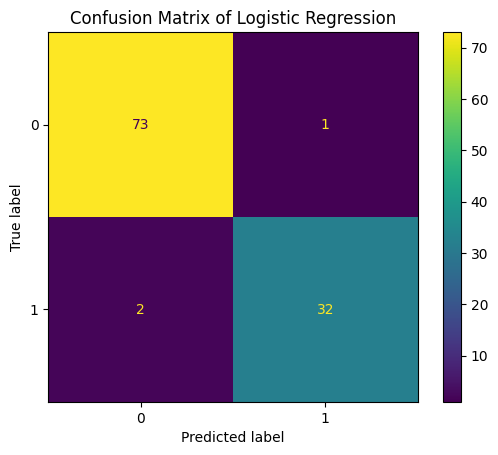

In [85]:
y_pred = best_lr.predict(X_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix of Logistic Regression")
plt.show()

# saving the data or more modeling

In [86]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.fit_transform(X_test)

In [87]:
with open('../data/preprocessed_data.pkl', 'wb') as f:
    pickle.dump((X_train_transformed, y_train, X_test_transformed, y_test), f)

In [88]:
with open('../models/log_reg.pkl', 'wb') as f:
    pickle.dump((best_lr), f)